# 20 News Groups Benchmark
## Sequence2class Model

La prima parte del benchmark viene effettuata con un modello denominato **sequence2class** che consiste in una rete neurale composta da un layer di **EMBEDDING** in input ad una **rete RNN (LSTM)** incaricata di apprendere gli embedding associati alle sequenze in input (preventivamente pre-processate con tecniche di NLP quali stemming, stopwording, lemmatizaztion, tokenization, sequencing etc...). L'uscita della rete LSTM va in input ad un **MLP** (incaricato della classificazione), composto da un layer hidden con 256 unità ed un layer di output con 20 unità corrispondenti ai 20newsgroups. 

Il modello è riassunto come segue:
<img src="./images/sequence2class.png" alt="sequence2class" width="700" />

In [1]:
import warnings
import time
import tensorflow as tf

In [2]:
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
from utils import *
from plots import *

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
MAX_SEQUENCE_LENGTH = 200     # lunghezza massima di una singola sequenza
EMBEDDING_DIM       = 300     # dimensione layer di embedding
LSTM_UNITS          = 150
VALIDATION_SPLIT    = 0.2
EPOCHS              = 50
BATCHES             = 32
NUM_CLASSES         = 20

In [6]:
# Load useful data
x_train           = loadPkl('x_train')
y_train           = loadPkl('y_train')
x_test            = loadPkl('x_test')
y_test            = loadPkl('y_test')

labels            = loadPkl('labels')
test_indicies     = loadPkl('test_indicies')
namesInLabelOrder = loadPkl('namesInLabelOrder')
word_index        = loadPkl('word_index')

## 1) Sequence2class 

In [6]:
'''
Costruiamo una rete neurale con un layer di embedding in ingresso ad una LSTM.
In uscita all LSTM mettiamo un MLP con un layer hidden e funzione
di attivazione lineare RELU ed un layer di output e funzione di 
attivazione SOFTMAX.
In questo caso i word embeddings sono appresi durante il fitting della rete
'''

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                               mode='auto',patience=3, verbose=2, 
                               restore_best_weights=False)

s2c_model = Sequential()
s2c_model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True,
                        mask_zero=True))

s2c_model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

s2c_model.add(Dense(256, activation='relu'))

s2c_model.add(Dense(NUM_CLASSES, activation='softmax'))

s2c_model.name = 'Sequence2Class'

s2c_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

print("Preparazione del modello...")
 
s2c_model.summary()

Preparazione del modello...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          32159100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                660       
Total params: 32,435,192
Trainable params: 32,435,192
Non-trainable params: 0
_________________________________________________________________


In [8]:
start_time = time.time()

s2c_history = s2c_model.fit(x=x_train,y=y_train,
                            epochs=EPOCHS,
                            batch_size=BATCHES,
                            shuffle=True,
                            validation_data=(x_test,y_test),
                            callbacks=[early_stop])

elapsed_time = time.time() - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print ('Time Taken:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

savePkl('s2c_history',s2c_history)
savePkl('s2c_model',s2c_model)

Train on 14636 samples, validate on 3660 samples
Epoch 1/50
14636/14636 [==============================] - 579s 40ms/step - loss: 2.4134 - acc: 0.1869 - val_loss: 1.9452 - val_acc: 0.3325
Epoch 2/50
14636/14636 [==============================] - 548s 37ms/step - loss: 1.4854 - acc: 0.4995 - val_loss: 1.3976 - val_acc: 0.5612
Epoch 3/50
14636/14636 [==============================] - 554s 38ms/step - loss: 0.7718 - acc: 0.7493 - val_loss: 1.3510 - val_acc: 0.6090
Epoch 4/50
14636/14636 [==============================] - 552s 38ms/step - loss: 0.3948 - acc: 0.8800 - val_loss: 1.4203 - val_acc: 0.6380
Epoch 5/50
14636/14636 [==============================] - 548s 37ms/step - loss: 0.2209 - acc: 0.9384 - val_loss: 1.5522 - val_acc: 0.6456
Epoch 6/50
14636/14636 [==============================] - 553s 38ms/step - loss: 0.1296 - acc: 0.9652 - val_loss: 1.6742 - val_acc: 0.6467
Epoch 00006: early stopping
Time Taken: 3333.250429868698


### Preparing result & Plotting

In [7]:
result = {}

# loading model and history
s2c_history       = loadPkl('s2c_history')
s2c_model         = loadPkl('s2c_model')

# building result
result['history'] = s2c_history.history
result['test_loss'], result['test_accuracy'] = s2c_model.evaluate(x_test, y_test, verbose=2)

# testing model on validation data
prediction        = s2c_model.predict(x_test, verbose=2)
prediction_labels = prediction.argmax(axis=1)

# building result
result['confusion_matrix'] = confusion_matrix(labels[test_indicies],prediction_labels).tolist()
result['classification_report'] = classification_report(labels[test_indicies],prediction_labels,digits=4,
                                                        target_names=namesInLabelOrder, output_dict=True)

# building confusion matrix
cm = result['confusion_matrix']
cm = np.array([np.array(xi) for xi in cm])

Generating confusion matrices...


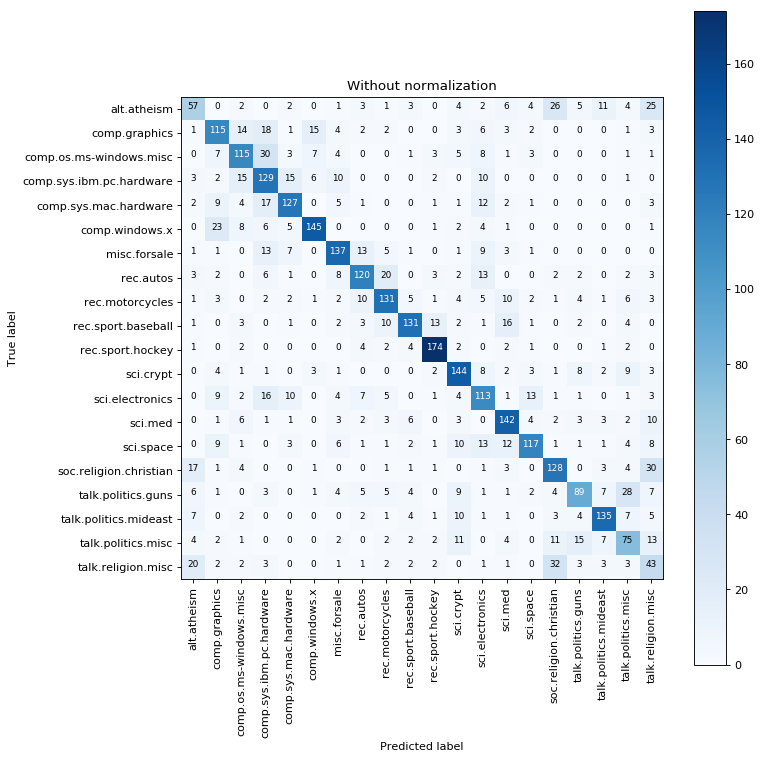

In [8]:
# plotting confusion matrix
plot_confusion_matrix(cm, 's2c_model', normalize=False, title='Without normalization')

Generating confusion matrices...


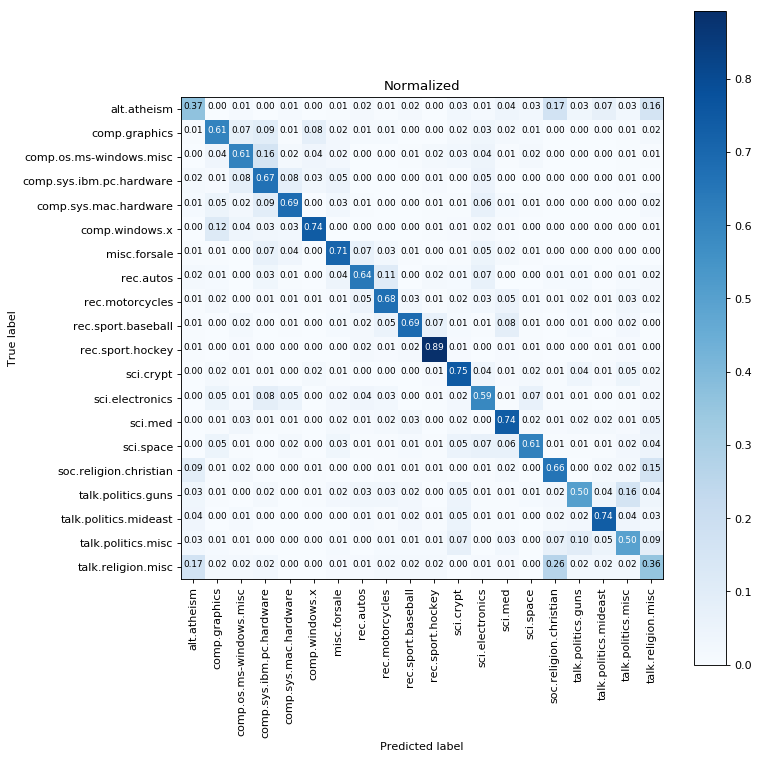

In [9]:
plot_confusion_matrix(cm, 's2c_model', normalize=True, title='Normalized')

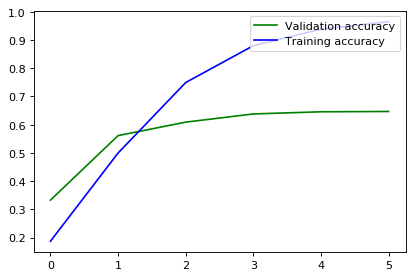

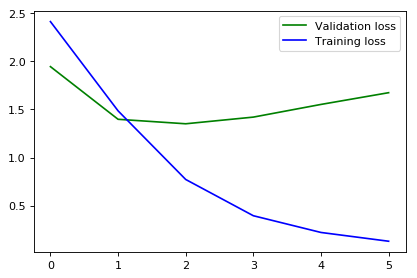

In [10]:
# plotting convergence
plotConvergence(result['history'],'s2c_model')

## 2) Sequence2class 
### (GloVe Pre-Trained Word Embeddings)

In [11]:
'''
Costruiamo una rete neurale con un layer di embedding in ingresso ad una LSTM.
In uscita all LSTM mettiamo un MLP con un layer hidden da 128 unità e funzione
di attivazione lineare RELU ed un layer di output con 2 unità e funzione di 
attivazione SOFTMAX.
In questo caso i word embeddings non sono appresi durante il fitting della rete
ma utilizzano dei word embeddings pre calcolati presenti nella matrice 'embedding_matrix'
calcolata usando vettori di parole pre calcolati (GloVe: Global Vector by Stanford NLP Group) 
'''
embedding_matrix = getEmbeddingMatrix(word_index)

early_GlV_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                               mode='auto',patience=3, verbose=2, 
                               restore_best_weights=False)

s2c_GlV_model = Sequential()
s2c_GlV_model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH,
                        weights=[embedding_matrix],
                        trainable=False,
                        mask_zero=True))

s2c_GlV_model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

s2c_GlV_model.add(Dense(256, activation='relu'))

s2c_GlV_model.add(Dropout(0.2))

s2c_GlV_model.add(Dense(NUM_CLASSES, activation='softmax'))

s2c_GlV_model.name = 'Sequence2Class'

s2c_GlV_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

print("Preparazione del modello...")
 
s2c_GlV_model.summary()

Preparazione del modello...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          32159100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 32,473,496
Trainable params: 314,396
Non-trainable params: 32,159,100
_________________________________________________________________


In [8]:
start_time = time.time()

s2c_GlV_history = s2c_GlV_model.fit(x=x_train,y=y_train,
                            epochs=EPOCHS,
                            batch_size=BATCHES,
                            shuffle=True,
                            validation_data=(x_test,y_test),
                            callbacks=[early_GlV_stop])

elapsed_time = time.time() - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print ('Time Taken:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

savePkl('s2c_GlV_history',s2c_GlV_history)
savePkl('s2c_GlV_model',s2c_GlV_model)

Train on 14636 samples, validate on 3660 samples
Epoch 1/50
14636/14636 [==============================] - 344s 24ms/step - loss: 1.9120 - acc: 0.3642 - val_loss: 1.4656 - val_acc: 0.5183
Epoch 2/50
14636/14636 [==============================] - 324s 22ms/step - loss: 1.2813 - acc: 0.5724 - val_loss: 1.1589 - val_acc: 0.6320
Epoch 3/50
14636/14636 [==============================] - 300s 20ms/step - loss: 1.0577 - acc: 0.6625 - val_loss: 1.0353 - val_acc: 0.6713
Epoch 4/50
14636/14636 [==============================] - 314s 21ms/step - loss: 0.9023 - acc: 0.7106 - val_loss: 1.0097 - val_acc: 0.6904
Epoch 5/50
14636/14636 [==============================] - 305s 21ms/step - loss: 0.7939 - acc: 0.7493 - val_loss: 0.9910 - val_acc: 0.7005
Epoch 6/50
14636/14636 [==============================] - 338s 23ms/step - loss: 0.6930 - acc: 0.7775 - val_loss: 0.9645 - val_acc: 0.7156
Epoch 7/50
14636/14636 [==============================] - 313s 21ms/step - loss: 0.5965 - acc: 0.8103 - val_loss: 0.9

### Preparing result & Plotting

In [13]:
GlV_result = {}

# loading model and history
s2c_GlV_history       = loadPkl('s2c_GlV_history')
s2c_GlV_model         = loadPkl('s2c_GlV_model')

# building result
GlV_result['history'] = s2c_GlV_history.history
GlV_result['test_loss'], GlV_result['test_accuracy'] = s2c_GlV_model.evaluate(x_test, y_test, verbose=2)

# testing model on validation data
GlV_prediction        = s2c_GlV_model.predict(x_test, verbose=2)
GlV_prediction_labels = GlV_prediction.argmax(axis=1)

# building result
GlV_result['confusion_matrix']      = confusion_matrix(labels[test_indicies],GlV_prediction_labels).tolist()
GlV_result['classification_report'] = classification_report(labels[test_indicies],GlV_prediction_labels,digits=4,
                                                        target_names=namesInLabelOrder, output_dict=True)

# building confusion matrix
GlV_cm = GlV_result['confusion_matrix']
GlV_cm = np.array([np.array(xi) for xi in GlV_cm])

Generating confusion matrices...


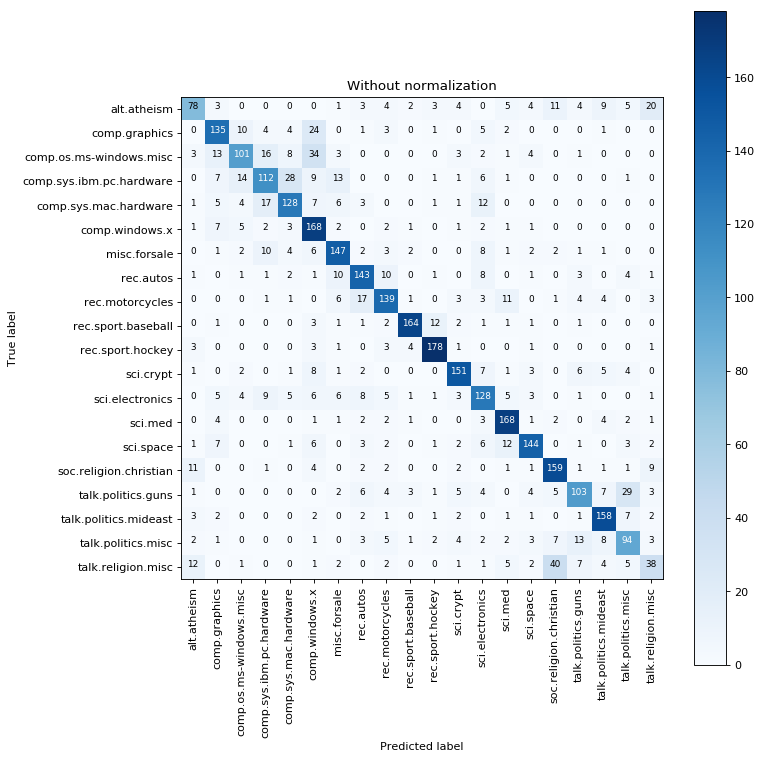

In [14]:
plot_confusion_matrix(GlV_cm, 's2c_GlV_model', normalize=False, title='Without normalization')

Generating confusion matrices...


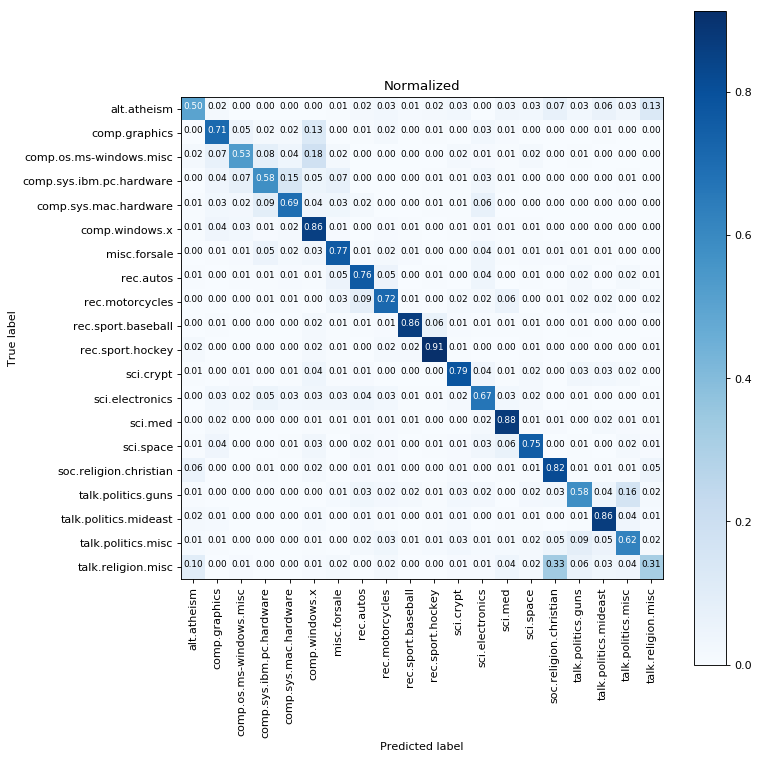

In [15]:
plot_confusion_matrix(GlV_cm, 's2c_GlV_model', normalize=True, title='Normalized')

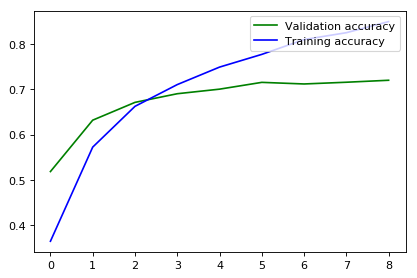

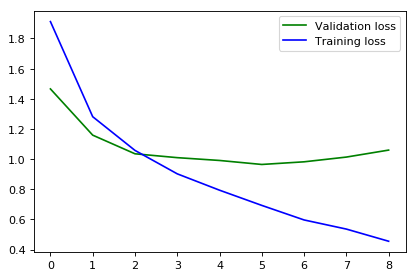

In [16]:
plotConvergence(GlV_result['history'],'s2c_GlV_model')

## End